In [86]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
#Combined model
df_images = pd.read_csv(r"C:\Users\Mirka Gemelova\OneDrive - ITU\Dokumenty\ITU\DS_project\2025-FYP-groupG\model_features.csv")
df_images2 = pd.read_csv(r"C:\Users\Mirka Gemelova\Downloads\features2.csv")
df_metadata = pd.read_csv(r"C:\Users\Mirka Gemelova\OneDrive - ITU\Dokumenty\ITU\DS_project\2025-FYP-groupG\important files to be deleted\metadata.csv")
combined_df = combined_df.dropna()


In [88]:
print(df_metadata.shape) #ImageID of removed image: PAT_987_1859_859
print(df_images.shape)
df_images['img_id'] = df_images2['ID']
combined_df = pd.merge(df_images, df_metadata, on='img_id', how='inner')
print(combined_df.shape)
combined_df2 = combined_df.copy()

(2298, 26)
(1473, 7)
(1473, 33)


In [89]:
#Data cleaning to be suitable for model
combined_df.replace("True", 1, inplace=True)
combined_df.replace("False", 0, inplace=True)
combined_df.replace(True, 1, inplace=True)
combined_df.replace(False, 0, inplace=True)
combined_df.replace("UNK", float("NaN"), inplace=True)

C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace("True", 1, inplace=True)
C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_df.replace(False, 0, inplace=True)
C:\Users\Mirka Gemelova\AppData\Local\Temp\ipykernel_29296\2042539058.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behav

In [90]:
combined_df = combined_df.drop(columns=['biopsed','img_id','patient_id', 'lesion_id', 'background_father',
      'background_mother', 'has_piped_water',
      'has_sewage_system', 'fitspatrick', 'region', 'diagnostic'])

print(combined_df.columns)
combined_df.head(5)

Index(['A - worst asymmetry', 'B - compactness', 'C - red variance',
       'C - green variance', 'C - blue variance', 'Hair', 'Cancer', 'smoke',
       'drink', 'age', 'pesticide', 'gender', 'skin_cancer_history',
       'cancer_history', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt',
       'changed', 'bleed', 'elevation'],
      dtype='object')


,A - worst asymmetry,B - compactness,C - red variance,C - green variance,C - blue variance,Hair,Cancer,smoke,drink,age,...,skin_cancer_history,cancer_history,diameter_1,diameter_2,itch,grew,hurt,changed,bleed,elevation
0,8.580224e+08,30.588197,74.546797,85.081084,86.207771,0.083847,0,0,0,14,...,0,1,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.190781e+06,201.571233,0.282972,0.534548,0.588560,0.031879,0,0,0,14,...,0,1,7.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.408456e+06,-1.067555,0.366330,0.496921,0.588388,0.070319,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0
3,1.853331e+06,-2.390464,2.952702,3.592146,4.158397,0.197232,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0
4,2.544890e+06,0.713480,0.615600,2.970867,3.926450,0.083589,1,1,1,59,...,0,0,20.0,15.0,1.0,1.0,1.0,0.0,1.0,1.0


In [91]:
combined_df.shape

(1473, 22)

x_train : (1178, 11)
y_train : (1178,)
x_test : (295, 11)
y_test : (295,)


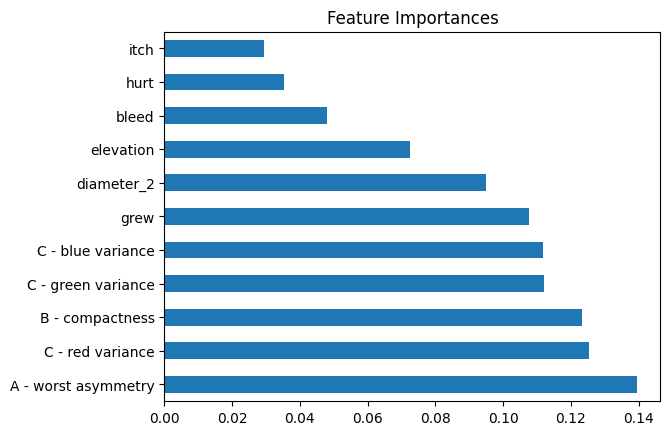

In [92]:
features_to_include = ['A - worst asymmetry', 'B - compactness', 'C - red variance',
       'C - green variance', 'C - blue variance', 
       'bleed', 'elevation', 'grew', 'hurt', 'itch', 'diameter_2']

y = combined_df['Cancer'].copy()
x = combined_df[features_to_include]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=101) #stratify = y makes sure that both training and test sets preserve the original class proportions.

print(f'x_train : {x_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_test : {y_test.shape}')

rf_model = RandomForestClassifier()
rf_model.fit(x_train, y_train)

feat_importances = pd.Series(rf_model.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

In [93]:
param_grid = [{
    'n_estimators':[100,200,500], #More trees = better performance up to a point, then diminishing returns.
    'max_depth': [3, 5, 10, 20], #higher the values the more we risk overfitting
    'criterion': ['entropy', 'gini'], #can also comment this out
    'min_samples_split': [5,10,15], # minimum number of samples a node must have to be split into two child nodes in a decision tree. Default is 2 (canm overfit)
    'min_samples_leaf': [1, 2, 4]#,
    #'max_features': ['sqrt', None]

}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)
grid_search = GridSearchCV(rf_model,
                           param_grid,
                           cv=skf, #this splits testing data to test and validation based on cancer/non-cancer proportions (so they have same percentage of cancer)
                                    #if we use this, we dont have to split training data ourselves at the beginning
                           scoring = 'recall',
                           n_jobs=-1,                          
                           )

grid_search.fit(x_train, y_train)

print(f'Grid search best score: {grid_search.best_score_}')
print(f'Grid search best parameters: {grid_search.best_params_}')

#Training the rf with what criteria recomended by grid search (= best parameters)
best_params = grid_search.best_params_

Grid search best score: 0.9666995073891625
Grid search best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


Train Report:
              precision    recall  f1-score   support

           0       0.78      0.33      0.47       307
           1       0.80      0.97      0.88       871

    accuracy                           0.80      1178
   macro avg       0.79      0.65      0.67      1178
weighted avg       0.80      0.80      0.77      1178

Confusion Matrix:
 [[102 205]
 [ 28 843]]

Test Report:
              precision    recall  f1-score   support

           0       0.78      0.40      0.53        77
           1       0.82      0.96      0.88       218

    accuracy                           0.81       295
   macro avg       0.80      0.68      0.71       295
weighted avg       0.81      0.81      0.79       295

Confusion Matrix:
 [[ 31  46]
 [  9 209]]


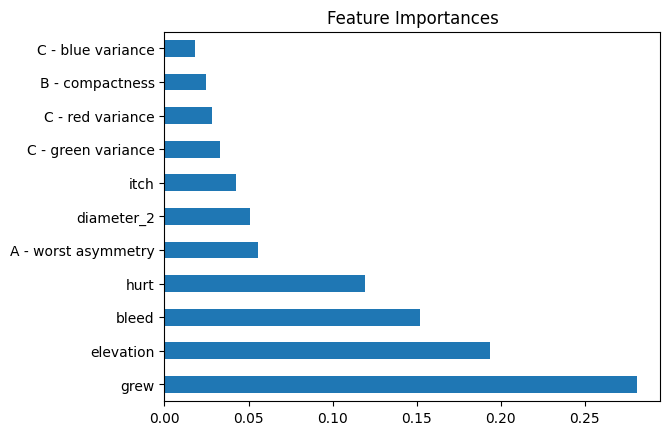

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


In [94]:
rf_final = RandomForestClassifier(**best_params, random_state=101) 
rf_final.fit(x_train, y_train)

#Evaluating on training and test set
y_pred = rf_final.predict(x_train)
print("Train Report:")
print(classification_report(y_train, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_pred))

y_test_pred = rf_final.predict(x_test)
print("\nTest Report:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

feat_importances = pd.Series(rf_final.feature_importances_, index=x.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Feature Importances")
plt.show()

# top performing features = bleed, elevation, hurt, grew, itch, smoke, changed, pesticide, cancer_history, skin_cancer history

print(best_params)

Cancer                 1.000000
grew                   0.381559
elevation              0.322112
bleed                  0.299446
hurt                   0.223536
itch                   0.134777
diameter_2             0.100437
C - green variance    -0.031219
C - red variance      -0.036823
C - blue variance     -0.040868
B - compactness       -0.055934
A - worst asymmetry   -0.066298
Name: Cancer, dtype: float64


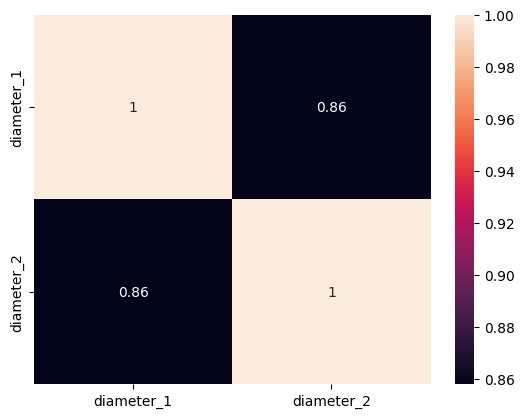

,diameter_1,diameter_2,Cancer
diameter_1,1.000000,0.858020,0.061889
diameter_2,0.858020,1.000000,0.100437
Cancer,0.061889,0.100437,1.000000


In [95]:

#TO BE DELETED!!!! (or moved)

print(combined_df[features_to_include + ['Cancer']].corr()['Cancer'].sort_values(ascending=False))

#our criteria: use everything above 0.05 correlation
# grew                   0.416786
# bleed                  0.357533
# elevation              0.341569
# hurt                   0.262078
# diameter_2             0.110892
# diameter_2             0.110892
# diameter_1             0.106564
# smoke                  0.085737
# itch                   0.070621

corr = combined_df[['diameter_1', 'diameter_2']].corr()
sns.heatmap(corr, annot=True)
plt.show()
2
combined_df[['diameter_1', 'diameter_2', 'Cancer']].corr()

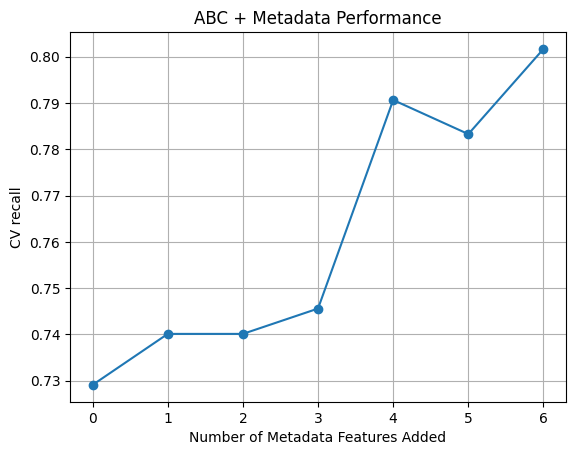

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt


abc_features = ['A - worst asymmetry', 'B - compactness', 'C - red variance',
       'C - green variance', 'C - blue variance']
metadata_features = ['grew', 'bleed', 'elevation', 'hurt', 'diameter_2','itch']
lifestyle_features = ['smoke', 'drink']  #pesticides missing and wotter/sewage missing
metadata_all = metadata_features + lifestyle_features

combined_df2 = combined_df2.notna()


X_meta = combined_df2[metadata_all]
y = combined_df2['Cancer']

# Ranking metadata features by mutual information
selector = SelectKBest(mutual_info_classif, k='all')
selector.fit(X_meta, y)

# Sort features by importance
importances = selector.scores_
ranked_metadata = [f for f, _ in sorted(zip(metadata_features, importances), key=lambda x: x[1], reverse=True)]

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

scores = []

for n in range(0, len(ranked_metadata) + 1):
    current_features = abc_features + ranked_metadata[:n]
    X = combined_df[current_features]
    y = combined_df['Cancer']

    model = DecisionTreeClassifier(random_state=42)
    cv_score = cross_val_score(model, X, y, cv=5, scoring='recall').mean()
    scores.append(cv_score)

# Plot performance vs number of metadata features
import matplotlib.pyplot as plt

plt.plot(range(len(scores)), scores, marker='o')
plt.xlabel('Number of Metadata Features Added')
plt.ylabel('CV recall')
plt.title('ABC + Metadata Performance')
plt.grid(True)
plt.show()

